In [1]:
import numpy as np
import os
import pylab as plt
import elephant
import matplotlib as mlib
%matplotlib inline

In [2]:
# ensure we use viridis as the default cmap
plt.viridis()

# ensure we use the same rc parameters for all matplotlib outputs
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 5})
mlib.rcParams.update({'figure.autolayout': True})
viridis_cmap = mlib.cm.get_cmap('viridis')

<Figure size 432x288 with 0 Axes>

In [3]:
import copy

ICUB_VOR_VENV_POP_SIZE = 2
POS_TO_VEL = 2 * np.pi * 0.001


# Examples of get functions for variables
def get_error(icub_vor_env_pop, simulator):
    b_vertex = icub_vor_env_pop._vertex
    error = b_vertex.get_data(
        'error', simulator.no_machine_time_steps, simulator.placements,
        simulator.buffer_manager, simulator.machine_time_step)
    return error.tolist()


def get_l_count(icub_vor_env_pop, simulator):
    b_vertex = icub_vor_env_pop._vertex
    left_count = b_vertex.get_data(
        'l_count', simulator.no_machine_time_steps, simulator.placements,
        simulator.buffer_manager, simulator.machine_time_step)
    return left_count.tolist()


def get_r_count(icub_vor_env_pop, simulator):
    b_vertex = icub_vor_env_pop._vertex
    right_count = b_vertex.get_data(
        'r_count', simulator.no_machine_time_steps, simulator.placements,
        simulator.buffer_manager, simulator.machine_time_step)
    return right_count.tolist()


def get_eye_pos(icub_vor_env_pop, simulator):
    b_vertex = icub_vor_env_pop._vertex
    head_positions = b_vertex.get_data(
        'eye_pos', simulator.no_machine_time_steps, simulator.placements,
        simulator.buffer_manager, simulator.machine_time_step)
    return head_positions.tolist()


def get_eye_vel(icub_vor_env_pop, simulator):
    b_vertex = icub_vor_env_pop._vertex
    head_velocities = b_vertex.get_data(
        'eye_vel', simulator.no_machine_time_steps, simulator.placements,
        simulator.buffer_manager, simulator.machine_time_step)
    return head_velocities.tolist()


def generate_head_position_and_velocity(time, dt=0.001):
    i = np.arange(0, time, dt)
    pos = -np.sin(i * 2 * np.pi)
    vel = -np.cos(i * 2 * np.pi)
    return pos, vel


def retrieve_and_package_results(icub_vor_env_pop, simulator):
    # Get the data from the ICubVorEnv pop
    errors = np.asarray(get_error(icub_vor_env_pop=icub_vor_env_pop, simulator=simulator)).ravel()
    l_counts = get_l_count(icub_vor_env_pop=icub_vor_env_pop, simulator=simulator)
    r_counts = get_r_count(icub_vor_env_pop=icub_vor_env_pop, simulator=simulator)
    rec_eye_pos = np.asarray(get_eye_pos(
        icub_vor_env_pop=icub_vor_env_pop, simulator=simulator)).ravel()
    rec_eye_vel = np.asarray(get_eye_vel(
        icub_vor_env_pop=icub_vor_env_pop, simulator=simulator)).ravel()
    results = {
        'errors': errors,
        'l_counts': l_counts,
        'r_counts': r_counts,
        'rec_eye_pos': rec_eye_pos,
        'rec_eye_vel': rec_eye_vel,
    }
    return results


def highlight_area(ax, runtime, start_nid, stop_nid):
    ax.fill_between(
        [0, runtime], start_nid, stop_nid,
        color='grey', alpha=0.1,
    )


def plot_results(results_dict, simulation_parameters, name):
    # unpacking results
    errors = results_dict['errors']
    l_counts = results_dict['l_counts']
    r_counts = results_dict['r_counts']
    rec_eye_pos = results_dict['rec_eye_pos']
    rec_eye_vel = results_dict['rec_eye_vel']

    # unpacking simulation params
    runtime = simulation_parameters['runtime']
    error_window_size = simulation_parameters['error_window_size']
    vn_spikes = simulation_parameters['vn_spikes']
    cf_spikes = simulation_parameters['cf_spikes']
    perfect_eye_pos = simulation_parameters['perfect_eye_pos']
    perfect_eye_vel = simulation_parameters['perfect_eye_vel']
    vn_size = simulation_parameters['vn_size']
    cf_size = simulation_parameters['cf_size']

    # plot the data from the ICubVorEnv pop
    x_plot = [(n) for n in range(0, runtime, error_window_size)]
    fig = plt.figure(figsize=(15, 20), dpi=400)
    # Spike raster plot
    ax = plt.subplot(5, 1, 1)
    highlight_area(ax, runtime, vn_size // 2, vn_size)
    first_half_filter = np.argwhere(vn_spikes[:, 0] < vn_size // 2)
    second_half_filter = ~first_half_filter
    plt.scatter(
        vn_spikes[second_half_filter, 1], vn_spikes[second_half_filter, 0],
        s=1, color=viridis_cmap(.75))
    plt.scatter(
        vn_spikes[first_half_filter, 1], vn_spikes[first_half_filter, 0],
        s=1, color=viridis_cmap(.25))

    plt.xlim([0, runtime])
    plt.ylim([0, vn_size])
    # L/R counts
    plt.subplot(5, 1, 2)
    plt.plot(x_plot, l_counts, 'o', color=viridis_cmap(.25), label="l_counts")
    plt.plot(x_plot, r_counts, 'o', color=viridis_cmap(.75), label="r_counts")
    plt.legend(loc="best")
    plt.xlim([0, runtime])
    # Positions and velocities
    plt.subplot(5, 1, 3)
    plt.plot(x_plot, rec_eye_pos, label="rec. eye position")
    plt.plot(x_plot, rec_eye_vel, label="rec. eye velocity")
    plt.plot(np.tile(perfect_eye_pos, runtime // 1000), label="eye position", ls=':')
    plt.plot(np.tile(perfect_eye_vel, runtime // 1000), label="eye velocity", ls=':')
    plt.legend(loc="best")
    plt.xlim([0, runtime])
    # Errors
    plt.subplot(5, 1, 4)
    plt.plot(x_plot, errors, label="rec. error")
    plt.plot(x_plot, np.tile(perfect_eye_pos[::error_window_size], runtime // 1000) - rec_eye_pos.ravel(),
             label="eye position diff")
    plt.plot(x_plot, np.tile(perfect_eye_vel[::error_window_size], runtime // 1000) - rec_eye_vel.ravel(),
             label="eye velocity diff")
    plt.legend(loc="best")
    plt.xlim([0, runtime])
    # Error spikes
    ax2 = plt.subplot(5, 1, 5)
    # plt.scatter(
    #     [i[1] for i in cf_spikes], [i[0] for i in cf_spikes], s=1)


    highlight_area(ax2, runtime, cf_size // 2, cf_size)
    first_half_filter = np.argwhere(cf_spikes[:, 0] < cf_size // 2)
    second_half_filter = ~first_half_filter
    plt.scatter(
        cf_spikes[second_half_filter, 1], cf_spikes[second_half_filter, 0],
        s=1, color=viridis_cmap(.75))
    plt.scatter(
        cf_spikes[first_half_filter, 1], cf_spikes[first_half_filter, 0],
        s=1, color=viridis_cmap(.25))
    # plt.legend(loc="best")
    plt.xlim([0, runtime])
    plt.ylim([0, cf_size])
    plt.xlabel("Time (ms)")
    save_figure(plt, name, extensions=[".png", ])
    plt.close(fig)


def remap_odd_even(original_spikes, size):
    remapped_spikes = copy.deepcopy(original_spikes)
    mapping = np.arange(size)
    mapping[::2] = np.arange(0, size, 2)
    mapping[1::2] = np.arange(size - 1, 0, -2)
    remapped_spikes[:, 0] = mapping[remapped_spikes[:, 0].astype(int)]
    return remapped_spikes


def remap_second_half_descending(original_spikes, size):
    remapped_spikes = copy.deepcopy(original_spikes)
    mapping = np.arange(size)
    mapping[:size//2] = np.arange(0, size//2, 1)
    mapping[size//2:] = np.arange(size, size//2, -1)
    remapped_spikes[:, 0] = mapping[remapped_spikes[:, 0].astype(int)]
    return remapped_spikes


def color_for_index(index, size, cmap=viridis_cmap):
    return cmap(index / (size + 1))


def write_sep():
    print("=" * 80)


def write_line():
    print("-" * 80)


def write_header(msg):
    write_sep()
    print(msg)
    write_line()


def write_short_msg(msg, value):
    print("{:40}:{:39}".format(msg, str(value)))


def write_value(msg, value):
    print("{:60}:{:19}".format(msg, str(value)))


def save_figure(plt, name, extensions=(".png",), **kwargs):
    for ext in extensions:
        write_short_msg("Plotting", name + ext)
        plt.savefig(name + ext, **kwargs)


This is how the compute error in the code on the NRP. Makes little sense to me but whatever.

In [4]:
def compute_P_error(kp, head_position, eye_position):
    error = kp * (head_position + eye_position)
    return error
def compute_D_error(kd, head_velocity, eye_velocity):
    error = kd * (head_velocity + eye_velocity)
    return error

They originally use kp and kd values of 15 and a "max amplitude" of 0.8. I got rid of all of these random values and I've tried to normalise everything between 0 and 1.

In [5]:
# Some sort of scaling factors?
# kp=15.0
# kd=15.0
kp=1.0
kd=1.0
MAX_AMPLITUDE = 0.8  # Not used

Loading pre-computed head positions and velocities for an entire experiment. In actuality, only the first 1000 samples are of interest here. These get repeated for the number of trials required for the full experiment. 

In [6]:
# Base dir
base_dir = "./"
head_pos = np.loadtxt(os.path.join(base_dir, "normalised_head_positions.csv"))
head_vel = np.loadtxt(os.path.join(base_dir, "normalised_head_velocities.csv"))

head_pos = (head_pos * 2.0) - 1.0
head_vel = (head_vel * 2.0) - 1.0

Making eye velocity and position be out of phase. These represent "perfection" for this experiment.

In [7]:
perfect_eye_vel = np.concatenate((head_vel[500:], head_vel[:500]))
perfect_eye_pos = np.concatenate((head_pos[500:], head_pos[:500]))

In [8]:
# Report 4 points:
for i in [0, 250, 500, 750]:
    print("At {}: head pos {:4.6f}, head vel {:4.6f}, eye pos {:4.6f}, eye vel {:4.6f}".format(
        i, head_pos[i], head_vel[i], perfect_eye_pos[i], perfect_eye_vel[i]))

At 0: head pos 0.000000, head vel -1.000000, eye pos -0.000000, eye vel 1.000000
At 250: head pos -1.000000, head vel 0.000000, eye pos 1.000000, eye vel 0.000000
At 500: head pos -0.000000, head vel 1.000000, eye pos 0.000000, eye vel -1.000000
At 750: head pos 1.000000, head vel 0.000000, eye pos -1.000000, eye vel -0.000000


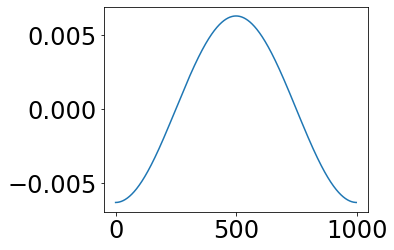

In [9]:
plt.plot(np.diff(head_pos[:1000]))

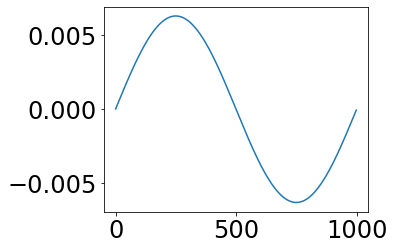

In [10]:
plt.plot(np.diff(head_vel[:1000]))

In [11]:
print(head_pos.size)
print(head_vel.size)
print(perfect_eye_vel.size)
print(perfect_eye_pos.size)

1000000
1000000
1000000
1000000


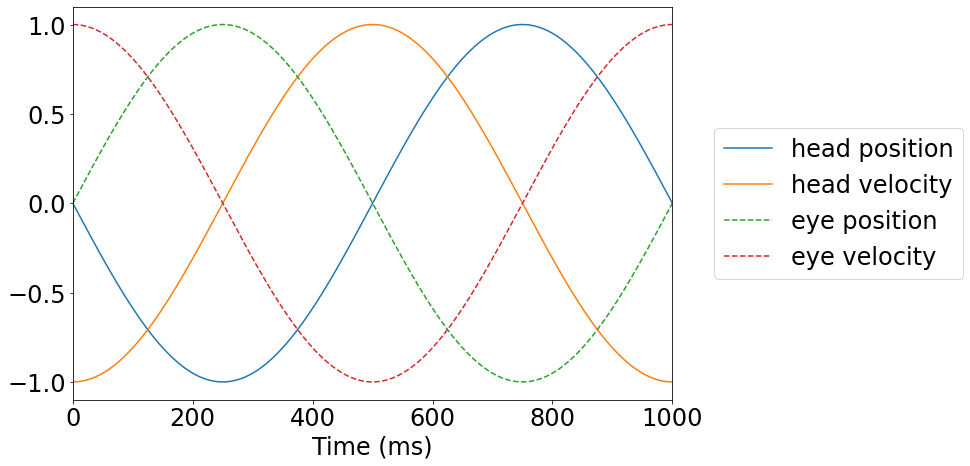

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(head_pos, label="head position")
plt.plot(head_vel, label="head velocity")
plt.plot(perfect_eye_pos, label="eye position", ls='--')
plt.plot(perfect_eye_vel, label="eye velocity", ls='--')
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.xlim([0, 1000])
plt.xlabel("Time (ms)")
plt.savefig("perfect_movement.pdf", dpi=300)
plt.show()

In [13]:
current_time = 0

# Error computation and rate setting

https://github.com/EduardoRosLab/VOR_in_neurorobotics/blob/master/error_activity.py

I assume that the error is meant to be in the range [-1, +1] because it is multiplied by 100 to get some sort of neuron ID. 

Does this mean that if the error has magnitude 1, the eye position / velocity combo is maximally bad, thus all CF should be active? So the maximum error is encoded as a high water mark in CF neuron space?

In [14]:
# These are my modified error definitions -- NOTE the minus signs
def compute_P_error(head_position, eye_position):
    return head_position - eye_position
def compute_D_error(head_velocity, eye_velocity):
    return head_velocity - eye_velocity

In [15]:
position_error = compute_P_error(head_pos[current_time+500], perfect_eye_pos[current_time+500])
print("Position error", position_error)

velocity_error = compute_D_error(head_vel[current_time+500], perfect_eye_vel[current_time+500])
print("Velocity error", position_error)

# error=(position_error * 0.1 + (velocity_error/(2.0*3.141592)) * 0.9)/MAX_AMPLITUDE
error = position_error

print("error", error)


Position error -3.3306690738754696e-16
Velocity error -3.3306690738754696e-16
error -3.3306690738754696e-16


(-1.1, 1.1)

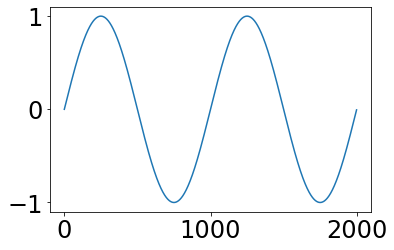

In [16]:
errs = []
for ct in range(2000):
    p_e = compute_P_error(head_pos[ct+500], perfect_eye_pos[0])
    v_e = compute_D_error(head_vel[ct+500], perfect_eye_vel[ct])
    e = p_e + v_e
    errs.append(e)
    
plt.plot(errs)
plt.ylim([-1.1, 1.1])

(-1.1, 1.1)

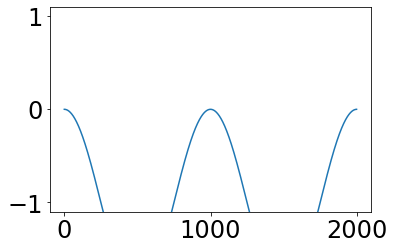

In [17]:
errs = []
for ct in range(2000):
    p_e = compute_P_error(head_pos[ct+500], perfect_eye_pos[ct])
    v_e = compute_D_error(head_vel[ct+500], perfect_eye_vel[0])
    e = p_e + v_e
    errs.append(e)
    
plt.plot(errs)
plt.ylim([-1.1, 1.1])

(-1.1, 1.1)

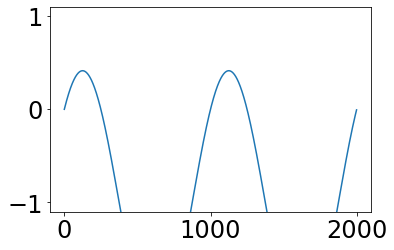

In [18]:
errs = []
for ct in range(2000):
    p_e = compute_P_error(head_pos[ct+500], perfect_eye_pos[0])
    v_e = compute_D_error(head_vel[ct+500], perfect_eye_vel[0])
    e = p_e + v_e
    errs.append(e)
    
plt.plot(errs)
plt.ylim([-1.1, 1.1])

Errors with a magnitude higher than 1 produce a kink in the response of CF (see below)

In [19]:
error=.5  # 0.3 0.5 0.1 -0.5

In [20]:
min_rate = 2.0
max_rate = 20.0
low_neuron_ID_threshold = abs(error) * 100.0
up_neuron_ID_threshold = low_neuron_ID_threshold - 100.0
IO_antagonist_activity = np.zeros(100)
IO_agonist_activity = np.zeros(100)


print(low_neuron_ID_threshold)
print(up_neuron_ID_threshold)
rate = []
for i in range (100):
    if(i < up_neuron_ID_threshold):
        rate.append(max_rate)
    elif(i<low_neuron_ID_threshold):
        aux_rate=max_rate - (max_rate-min_rate)*((i - up_neuron_ID_threshold)/(low_neuron_ID_threshold - up_neuron_ID_threshold))
        rate.append(aux_rate)
    else:
        rate.append(min_rate)
if error>=0.0:
    IO_agonist_activity[:]=min_rate
    IO_antagonist_activity[:]=rate
else:
    IO_antagonist_activity[:]=min_rate
    IO_agonist_activity[:]=rate

50.0
-50.0


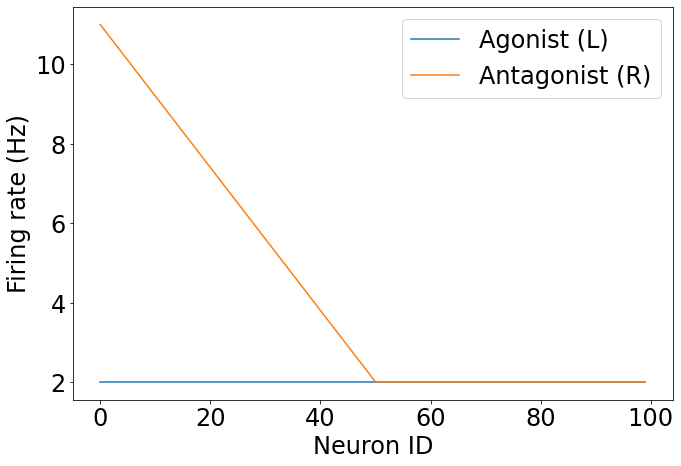

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(IO_agonist_activity, label="Agonist (L)")
plt.plot(IO_antagonist_activity, label="Antagonist (R)")
plt.xlabel("Neuron ID")
plt.ylabel("Firing rate (Hz)")
plt.legend(loc="best")
plt.show()

In [22]:
np.sum(IO_antagonist_activity) / 100.

4.295

In [23]:
IO_agonist_activity

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [24]:
IO_antagonist_activity

array([11.  , 10.82, 10.64, 10.46, 10.28, 10.1 ,  9.92,  9.74,  9.56,
        9.38,  9.2 ,  9.02,  8.84,  8.66,  8.48,  8.3 ,  8.12,  7.94,
        7.76,  7.58,  7.4 ,  7.22,  7.04,  6.86,  6.68,  6.5 ,  6.32,
        6.14,  5.96,  5.78,  5.6 ,  5.42,  5.24,  5.06,  4.88,  4.7 ,
        4.52,  4.34,  4.16,  3.98,  3.8 ,  3.62,  3.44,  3.26,  3.08,
        2.9 ,  2.72,  2.54,  2.36,  2.18,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ])

In [25]:
# Here I could generate a map of firing rates assuming unmoving eyes and a swivel of the head.

# Eye twist experiments

From https://github.com/EduardoRosLab/VOR_in_neurorobotics/blob/master/eye_twist.py

```
def eye_twist(t, agonist_neuron, antagonist_neuron):
    MAX_AMPLITUDE = 0.8
    eye_velocity=((agonist_neuron.rate - antagonist_neuron.rate)/(100.0*85.0))*MAX_AMPLITUDE*2.0*3.141592*1.55
        
    #clientLogger.info(t, agonist_neuron.rate, antagonist_neuron.rate, eye_velocity)
    if abs(eye_velocity)>MAX_AMPLITUDE*2.0*3.141592*1.55*1.2:
        sign=eye_velocity/(abs(eye_velocity))# + or -
        eye_velocity=MAX_AMPLITUDE*2.0*3.141592*1.5*1.2*sign   

    return std_msgs.msg.Float64(eye_velocity)
```

In [26]:
# attempt at capturing floating numbers
MAX_AMPLITUDE = 0.8
NORM_FACTOR = (100.0*85.0)
SCALE_UP_FACTOR = MAX_AMPLITUDE*2.0*np.pi*1.55
THRESH = MAX_AMPLITUDE*2.0*np.pi*1.55*1.2

In [27]:
SCALE_UP_FACTOR

7.791149780902687

In [28]:
THRESH

9.349379737083224

In [29]:
# simulated rates
no_points = 10000
agonist_counts = np.arange(-no_points, no_points)
antagonist_counts = [0] * (2*no_points)
# computed velocities
sim_eye_vel = ((agonist_counts - antagonist_counts) / NORM_FACTOR) * SCALE_UP_FACTOR

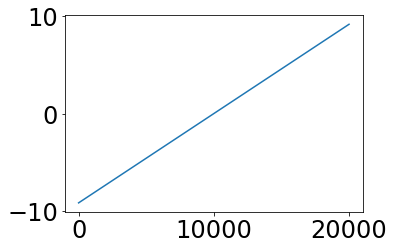

In [30]:
plt.plot(sim_eye_vel)

In [31]:
thesh_filter = np.abs(sim_eye_vel)>THRESH
sim_eye_vel[thesh_filter] = np.sign(sim_eye_vel[thesh_filter]) * THRESH

In [32]:
np.where(thesh_filter)

(array([], dtype=int64),)

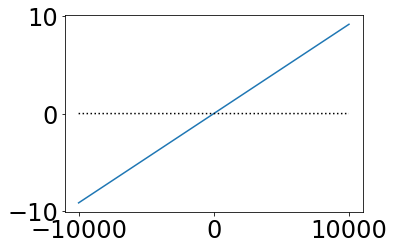

In [33]:
plt.plot(agonist_counts, sim_eye_vel)
plt.plot(agonist_counts, antagonist_counts, color='k', ls=":")

In [34]:
from brian2.units import *

In [35]:
10000 / (10 * 100) 

10.0

In [36]:
pre_syn_neurons = 100
slot_dt = 10

In [37]:
sim_2 = (agonist_counts - antagonist_counts) 

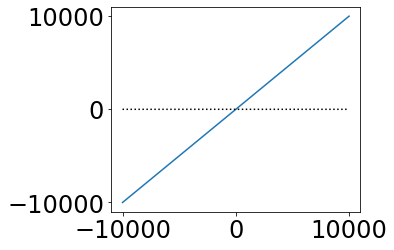

In [38]:
plt.plot(agonist_counts, sim_2)
plt.plot(agonist_counts, antagonist_counts, color='k', ls=":")

In [39]:
_head_pos = []
_head_vel = []
i = np.arange(0, 1, 0.001)
for t in i:
    desired_pos = -np.sin(t * 2 * np.pi) 
    desired_speed = -np.cos(t * 2 * np.pi) * 2.0 * np.pi
    _head_pos.append(desired_pos)
    _head_vel.append(desired_speed)

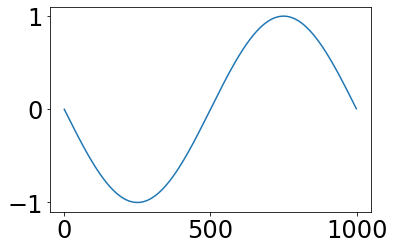

In [40]:
plt.plot(_head_pos[:1000])

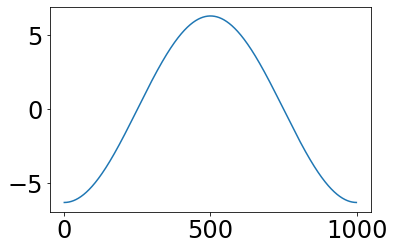

In [41]:
plt.plot(_head_vel[:1000])

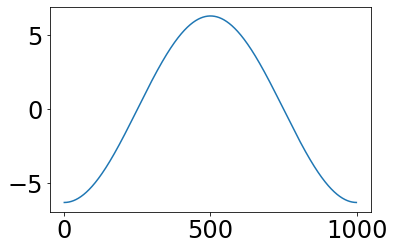

In [42]:
plt.plot((-np.cos(i * 2 * np.pi) * 2.0 * np.pi)[:1000])

In [43]:
def generate_head_position_and_velocity(steps, dt=0.001):
    _i = np.arange(0, steps, dt)
    _pos = -np.sin(2 * _i * np.pi)
    _vel = -np.cos(2 * _i * np.pi)
    return _pos, _vel

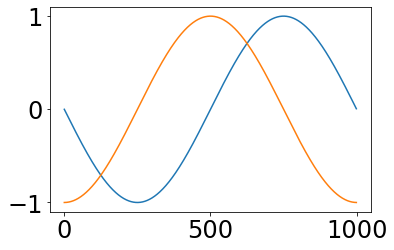

In [44]:
i = np.arange(0, 1, 0.001)
plt.plot(-np.sin(2 * i * np.pi))
plt.plot(-np.cos(2 * i * np.pi))

In [45]:
slowdown=50
pos_to_vel = 1/ (0.001 * 2 * np.pi * slowdown)

In [46]:
pos_to_vel

3.183098861837907

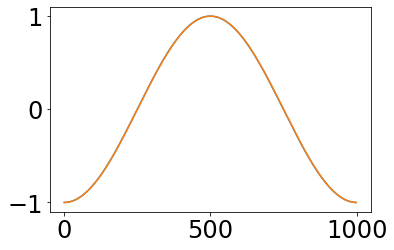

In [47]:
plt.plot(np.diff(generate_head_position_and_velocity(1)[0])*pos_to_vel*slowdown)
plt.plot(generate_head_position_and_velocity(1)[1])


In [48]:
def round_to_nearest_accum(x, shift):
    eps = 2. ** (-15 + shift)
    x_approx = np.floor((x / eps) + 0.5) * eps
    return x_approx

In [49]:
round_to_nearest_accum(pos_to_vel/10, 0)

0.31829833984375

In [50]:
sub_eye_pos = np.diff(perfect_eye_pos)

In [51]:
pos_to_vel

3.183098861837907

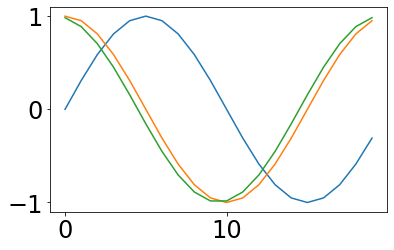

In [52]:
plt.plot(perfect_eye_pos[:1000:slowdown])
plt.plot(perfect_eye_vel[:1000:slowdown])
plt.plot(np.diff(perfect_eye_pos[:1001:slowdown])*pos_to_vel)

In [53]:
slowdown = 10
gain = 20.0
vel_to_pos = 1/ (2 * np.pi * slowdown * gain)

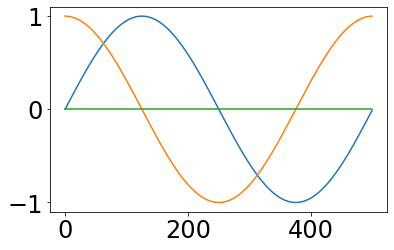

In [54]:
plt.plot(perfect_eye_pos[:1000:2])
plt.plot(perfect_eye_vel[:1000:2])
plt.plot(np.diff(perfect_eye_pos[:1001:2])*vel_to_pos)

In [55]:
vel_to_pos

0.0007957747154594767

In [56]:
pos_to_vel

3.183098861837907

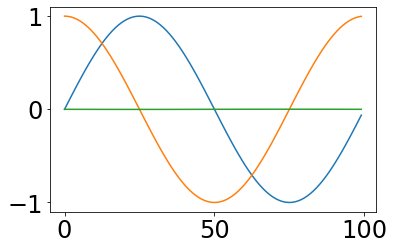

In [57]:
plt.plot(perfect_eye_pos[:1000:slowdown])
plt.plot(perfect_eye_vel[:1000:slowdown])
plt.plot(np.diff(perfect_eye_vel[:1000+slowdown:slowdown])*gain*vel_to_pos)

In [58]:
(10 * gain)/(2 * np.pi)

31.830988618379067

In [59]:
np.diff(perfect_eye_pos[:1000:10])

array([ 0.06279052,  0.06254271,  0.06204808,  0.06130857,  0.06032711,
        0.05910756,  0.05765474,  0.05597438,  0.05407312,  0.05195846,
        0.04963874,  0.04712312,  0.04442152,  0.04154462,  0.03850375,
        0.03531093,  0.03197875,  0.02852037,  0.02494943,  0.02128003,
        0.01752664,  0.01370409,  0.00982745,  0.00591203,  0.00197327,
       -0.00197327, -0.00591203, -0.00982745, -0.01370409, -0.01752664,
       -0.02128003, -0.02494943, -0.02852037, -0.03197875, -0.03531093,
       -0.03850375, -0.04154462, -0.04442152, -0.04712312, -0.04963874,
       -0.05195846, -0.05407312, -0.05597438, -0.05765474, -0.05910756,
       -0.06032711, -0.06130857, -0.06204808, -0.06254271, -0.06279052,
       -0.06279052, -0.06254271, -0.06204808, -0.06130857, -0.06032711,
       -0.05910756, -0.05765474, -0.05597438, -0.05407312, -0.05195846,
       -0.04963874, -0.04712312, -0.04442152, -0.04154462, -0.03850375,
       -0.03531093, -0.03197875, -0.02852037, -0.02494943, -0.02

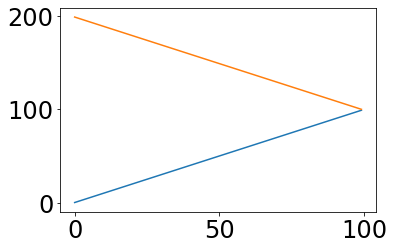

In [60]:
input_size=200
mapping = np.arange(input_size)
mapping[::2] = np.arange(0, input_size, 2) // 2
mapping[1::2] =input_size//2 + np.arange(input_size-1, 0, -2) // 2
plt.plot(mapping[::2])
plt.plot(mapping[1::2])
plt.grid(plt.grid())

In [61]:
potential_mapping = np.array([0, 0, 101, 101, 101, 1, 1, 199])

In [62]:
mapping[potential_mapping]

array([  0,   0, 149, 149, 149, 199, 199, 100])

In [63]:
109//2

54

In [64]:
input_spike_ids = []
for i in range(5):
    input_spike_ids.append(i * 2)
    input_spike_ids.append(2 * i + 1) 
    input_spike_ids.append(50 + i * 2)
    input_spike_ids.append(100 + 2 * i + 1)
    input_spike_ids.append(150 + i * 2)
    input_spike_ids.append(150 + 2 * i + 1) 
input_spike_ids = np.asarray(input_spike_ids)

In [65]:
input_spike_ids[input_spike_ids%2==1]

array([  1, 101, 151,   3, 103, 153,   5, 105, 155,   7, 107, 157,   9,
       109, 159])

In [66]:
mapping[input_spike_ids][input_spike_ids%2==1]

array([199, 149, 124, 198, 148, 123, 197, 147, 122, 196, 146, 121, 195,
       145, 120])

In [67]:
mapping[:input_size:2]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [68]:
mapping[1:input_size:2]

array([199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187,
       186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174,
       173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161,
       160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148,
       147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135,
       134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122,
       121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109,
       108, 107, 106, 105, 104, 103, 102, 101, 100])

In [69]:
import copy
def remap_second_half_descending(original_spikes, size):
    remapped_spikes = copy.deepcopy(original_spikes)
    mapping = np.arange(size)
    mapping[:size//2] = np.arange(0, size//2, 1)
    mapping[size//2:] = np.arange(size, size//2, -1)
    remapped_spikes[:, 0] = mapping[remapped_spikes[:, 0].astype(int)]
    return remapped_spikes

In [70]:
x = np.array([[0, 1], [1, 4], [100, 2], [105, 3]])

In [71]:
remap_second_half_descending(x, 200)

array([[  0,   1],
       [  1,   4],
       [200,   2],
       [195,   3]])

In [72]:
# Parameter definition
runtime = 3000
# Build input SSP and output population
input_size = 200  # neurons
output_size = 200  # neurons
gain = 20.0

head_pos, head_vel = generate_head_position_and_velocity(1)

# perfect eye positions and velocities are exactly out of phase with head
perfect_eye_pos = np.concatenate((head_pos[500:], head_pos[:500]))
perfect_eye_vel = np.concatenate((head_vel[500:], head_vel[:500]))

# the constant number (0.000031) is the effect of a single spike on the head position
# assert (np.isclose(np.abs(np.diff(head_pos)[0]), no_required_spikes_per_chunk * 0.000031), 0.001)
sub_head_pos = np.diff(head_pos)
head_movement_per_spike = 2 ** (-15) * gain
sub_eye_pos = np.diff(np.concatenate((perfect_eye_pos, [perfect_eye_pos[0]])))

# no_required_spikes_per_chunk = 200
no_required_spikes_per_chunk = np.ceil(np.abs(sub_head_pos[0]) / head_movement_per_spike)

# build ICubVorEnv model pop
error_window_size = 10  # ms
npc_limit = 200
no_input_cores = int(input_size / npc_limit)

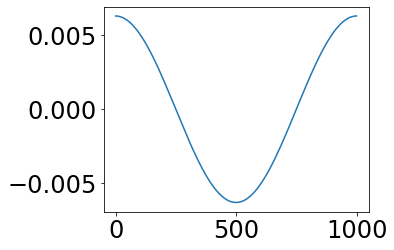

In [73]:
plt.plot(sub_eye_pos)

In [74]:
input_spike_times = [[] for _ in range(input_size)]
for ts in range(runtime - 1):
    sgn = sub_eye_pos[ts % 1000]
    spikes_during_chunk = np.ceil(np.abs(sub_eye_pos[ts % 1000]) / head_movement_per_spike)
    for i in range(int(spikes_during_chunk)):
        x = int(sgn <= 0)
        input_spike_times[(i % no_input_cores) * npc_limit + x].append(ts)

In [75]:
count_odd_spikes = np.zeros(runtime)
count_even_spikes = np.zeros(runtime)
for _ind, st in enumerate(input_spike_times):
    if len(st) > 0:
        print(_ind)
        for t in st:
            if _ind % 2 == 0:
                count_even_spikes[t] += 1
            else:
                count_odd_spikes[t] += 1

0
1


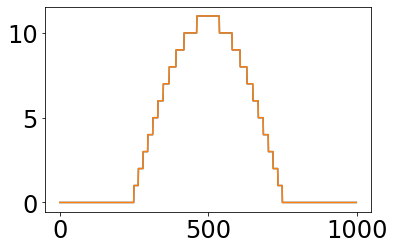

In [76]:
plt.plot(count_odd_spikes[:1000])
plt.plot(count_even_spikes[500:1500])

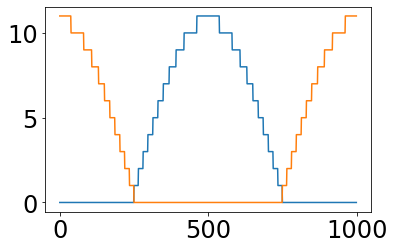

In [77]:
plt.plot(count_odd_spikes[:1000])
plt.plot(count_odd_spikes[500:1500])

# PF-PC TESTS


## First paper
![PF PC paper 1 ss](pf_pc_plasticity.jpg "Title")

PF-PC

  - Plasticity of pf (GrC) synapses formed on PC
  - CF spikes modulate the LTD here
  - LTP is constant

the LTP constant is undefined in the paper

$\tau_{LTD}$ is not defined in the paper, so I'm going by OR's description: $$\tau_{LTD}=\frac{t_{peak}}{atan(20)}$$

## Second paper
![PF PC paper 1 ss](pf_pc_plasticity_2nd_paper.jpg "Title")

The second paper would suggest using alpha=-0.0304 nS and beta=0.0184


## Learning parameters

min_weight = 0

max_weight = 0.1

pot_alpha = 0.01

t_peak = 100

In [78]:
import math
import numpy
STDP_FIXED_POINT_ONE = (1 << 11)


# def float_to_fixed(value):
#     """
#     :param float value:
#     :rtype: int
#     """
#     return int(round(float(value) * STDP_FIXED_POINT_ONE))

def float_to_fixed(value, fixed_point_one):
    return int(round(float(value) * float(fixed_point_one)))

def get_lut_provenance(
        pre_population_label, post_population_label, rule_name, entry_name,
        param_name, last_entry):
    # pylint: disable=too-many-arguments
    top_level_name = "{}_{}_STDP_{}".format(
        pre_population_label, post_population_label, rule_name)
    report = False
    if last_entry is not None:
        report = last_entry > 0
    return ProvenanceDataItem(
        [top_level_name, entry_name], last_entry, report=report,
        message=(
            "The last entry in the STDP exponential lookup table for the {}"
            " parameter of the {} between {} and {} was {} rather than 0,"
            " indicating that the lookup table was not big enough at this"
            " timestep and value.  Try reducing the parameter value, or"
            " increasing the timestep".format(
                param_name, rule_name, pre_population_label,
                post_population_label, last_entry)))

def get_exp_lut_array(time_step, time_constant, shift=0):
    """
    :param int time_step:
    :param float time_constant:
    :param int shift:
    :rtype: ~numpy.ndarray
    """
    # Compute the actual exponential decay parameter
    # NB: lambda is a reserved word in Python
    l_ambda = time_step / float(time_constant)

    # Compute the size of the array, which must be a multiple of 2
    size = math.log(STDP_FIXED_POINT_ONE) / l_ambda
    size, extra = divmod(size / (1 << shift), 2)
    size = ((int(size) + (extra > 0)) * 2)

    # Fill out the values in the array
    a = numpy.exp((numpy.arange(size) << shift) * -l_ambda)
    a = numpy.floor(a * STDP_FIXED_POINT_ONE)

    # Concatenate with the header
    header = numpy.array([len(a), shift], dtype="uint16")
    return numpy.concatenate((header, a.astype("uint16"))).view("uint32")


def write_pfpc_lut(spec, peak_time, lut_size, shift, time_probe,
                   fixed_point_one=STDP_FIXED_POINT_ONE):
    # Add this to function arguments in the future
    machine_time_step = 1.0
    sin_pwr = 20

    # Calculate required time constant
    time_constant = peak_time / math.atan(sin_pwr)
    inv_tau = (1.0 / float(time_constant))  # * (machine_time_step / 1000.0)

    #         # caluclate time of peak (from differentiating kernel and setting to zero)
    #         kernel_peak_time = math.atan(20) / inv_tau

    # evaluate peak value of kernel to normalise LUT
    kernel_peak_value = (math.exp(-peak_time * inv_tau) *
                         math.sin(peak_time * inv_tau) ** sin_pwr)

    # Generate LUT
    out_float = []
    out_fixed = []

    final_exp_fix = []

    for i in range(0, lut_size):  # note that i corresponds to 1 timestep!!!!!!

        # Multiply by inverse of time constant
        value = float(i) * inv_tau

        # Only take first peak from kernel
        if (value > math.pi):
            exp_float = 0
        else:
            # Evaluate kernel
            exp_float = math.exp(-value) * math.sin(value) ** sin_pwr / kernel_peak_value

        # Convert to fixed-point
        exp_fix = float_to_fixed(exp_float, fixed_point_one)

        if spec is None:  # in testing mode so print
            out_float.append(exp_float)
            out_fixed.append(exp_fix)
            if i == time_probe:
                print("dt = {}, kernel value = {} (fixed-point = {})".format(
                    time_probe, exp_float, exp_fix))

        else:  # at runtime, so write to spec
            final_exp_fix.append(exp_fix)
            # spec.write_value(data=exp_fix, data_type=DataType.INT16)

    if spec is None:
        print("peak: time {}, value {}".format(peak_time, kernel_peak_value))
        t = numpy.arange(0, lut_size)
        plt.plot(t, out_float, label='float')
        # plt.plot(t,out_fixed, label='fixed')
        plt.legend()
        plt.title("pf-PC LUT")
        plt.savefig("figures/write_pfpc_lut.png")
        # plt.show()
        return t, out_float
    else:
        # exp_fix_array_int16 = numpy.asarray(
        #     final_exp_fix, dtype="uint16").view("uint32")

        spec.write_array(final_exp_fix, data_type=DataType.INT16)

def write_mfvn_lut(spec, sigma, beta, lut_size, shift, time_probe,
                   fixed_point_one=STDP_FIXED_POINT_ONE):
    # Add this to function arguments in the future
    machine_time_step = 1.0
    cos_pwr = 2

    # Calculate required time constant
    inv_sigma = (1.0 / float(sigma))  # * (machine_time_step / 1000.0)
    peak_time = 0

    # evaluate peak value of kernel to normalise LUT
    kernel_peak_value = (math.exp(-abs(peak_time * inv_sigma * beta)) *
                         math.cos(peak_time * inv_sigma) ** cos_pwr)

    # Generate LUT
    out_float = []
    out_fixed = []
    plot_times = []

    final_exp_fix = []

    for i in range(0, lut_size):  # note that i corresponds to 1 timestep!!!!!!

        # Multiply by inverse of time constant
        value = float(i) * inv_sigma

        # Only take first peak from kernel
        if (value > math.pi / 2):
            exp_float = 0
        else:
            # Evaluate kernel
            exp_float = math.exp(-abs(value * beta)) * math.cos(value) ** cos_pwr / kernel_peak_value

        # Convert to fixed-point
        exp_fix = float_to_fixed(exp_float, fixed_point_one)

        if spec is None:  # in testing mode so print
            out_float.append(exp_float)
            out_fixed.append(exp_fix)
            plot_times.append(i)
            if i == time_probe:
                print("dt = {}, kernel value = {} (fixed-point = {})".format(
                    time_probe, exp_float, exp_fix))

        else:  # at runtime, so write to spec
            final_exp_fix.append(exp_fix)
            # spec.write_value(data=exp_fix, data_type=DataType.INT16)

    if spec is None:
        print("peak: time {}, value {}".format(peak_time, kernel_peak_value))
        plt.plot(plot_times, out_float, label='float')
        # plt.plot(t,out_fixed, label='fixed')
        plt.legend()
        plt.title("mf-VN LUT")
        plt.savefig("figures/write_mfvn_lut.png")
        # plt.show()
        return plot_times, out_float
    else:
        # exp_fix_array_int16 = numpy.asarray(
        #     final_exp_fix, dtype="uint16").view("uint32")

        spec.write_array(final_exp_fix, data_type=DataType.INT16)

In [79]:
potentiation_constant = 0.01 * nS / uS
potentiation_constant

1e-05

In [80]:
assert np.arctan(20) == math.atan(20)

In [81]:
t_peak = 100 # peak at 100 ms 
tau_ltd = t_peak / np.arctan(20)
x = np.arange(0,500, 1) / tau_ltd
y = (np.e**(-x)) * (np.sin(x)**20)

In [82]:
1./tau_ltd

0.015208379310729539

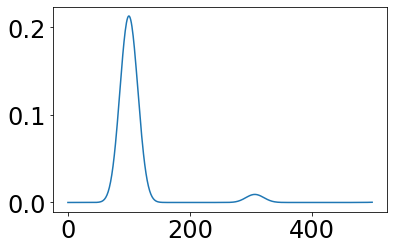

In [83]:
plt.plot(y)

dt = 100, kernel value = 1.0 (fixed-point = 2048)
peak: time 100, value 0.2131398548795243


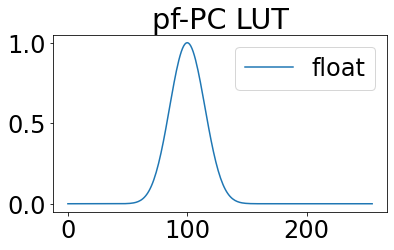

In [84]:


# sin_power=20
t_peak = 100

pfpc_lut = write_pfpc_lut(spec=None,
               peak_time=t_peak,
               lut_size=256,
               shift=0,
               time_probe=t_peak)

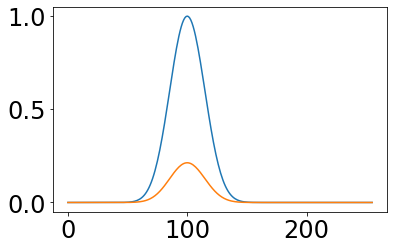

In [85]:
plt.plot(pfpc_lut[0], pfpc_lut[1])
plt.plot(y[:256])

In [86]:
pfpc_lut[0][-1]

255

# MF-VN plasticity
## First paper
![alt text](mf_vn_plasticity.jpg "Title")
## Second paper
![alt text](mf_vn_plasticity_2nd_paper.jpg "Title")

The second paper would suggest alpha=-0.002048 nS and beta=0.000792 nS

MF-VN

  - Plasticity of MF synapses formed on VN
  - PC spikes modulate the LTD here
  - LTP is constant

## Learning parameters
min_weight = 0

max_weight = 0.1

pot_alpha = 0.01  

beta = 11

sigma = 201


In [87]:
524288 & 0xFFFF0000

524288

In [88]:
524288 >> 16

8

In [89]:
def ff_1_to_1_odd_even_mapping(no_nids):
    sources = np.arange(no_nids)
    targets = np.ones(no_nids) * np.nan
    targets[:no_nids//2] = sources[:no_nids//2]*2
    targets[no_nids//2:] = ((sources[no_nids//2:]-no_nids//2)*2) + 1
    return np.vstack((sources, targets))

In [90]:
ff_1_to_1_odd_even_mapping(200).shape

(2, 200)

In [91]:
np.vstack((np.arange(20), np.repeat(0, 20)))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])